In [1]:
# %load mlpack.py
# %load mlpack.py
# %load mlpack.py

#Suppress Warninings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sb
from sklearn.metrics import accuracy_score,r2_score,classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

def read_basic(name=None):
	if(name==None):
		raise ValueError('No File Name provided')
		return 0

	df = pd.read_csv(name)
	print('Datatypes: \n', df.dtypes)
	print('-----------------------------\n')
	print('Dimension: \n', df.shape)
	print('-----------------------------\n')
	print('Missing values per column: \n', df.isna().sum())
	print('-----------------------------\n')
	print('Dataframe Info: \n', df.info())
	print('-----------------------------\n')
	print('Descriptive Stats: \n', df.describe())

	return df# %load mlpack.py


c:\python36\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
titanic_df = read_basic('train.csv')

Datatypes: 
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
-----------------------------

Dimension: 
 (891, 12)
-----------------------------

Missing values per column: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float6

Datatypes: 
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
-----------------------------

Dimension: 
 (891, 12)
-----------------------------

Missing values per column: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float6

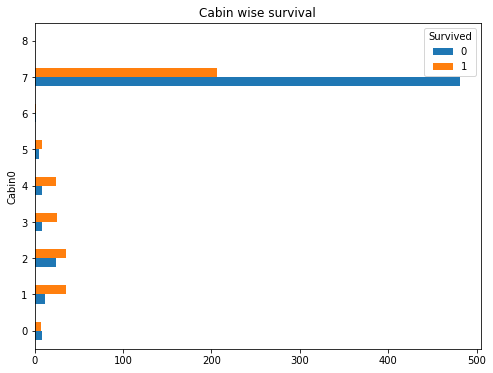

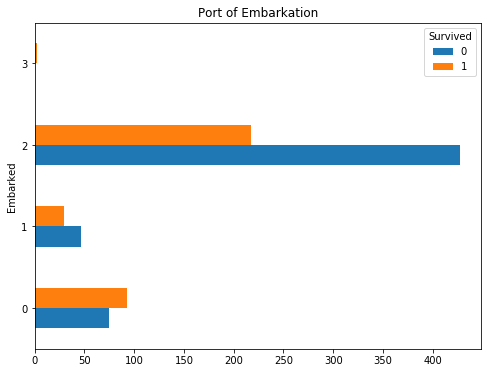

In [3]:
# Datatypes: 

# Survived         int64 : Target
# Pclass           int64 : Ticket class, High correlationg with Cabin0, hence removed
# Age            float64 : Numeric, non-ordinal
# SibSp            int64 : Numeric, number of siblings
# Fare           float64 : Ordinal feature
# Parch            int64 : # of parents / children aboard the Titanic, Numeric

#  PassengerId      int64 : Removed, nominal feature
# Name            object : Removed, nominal feature
# Ticket          object : Ticket number, Removed

# Sex             object : Gender, can be made boolean
# Cabin0           object : Cabin number, categorical, New feature
# Embarked        object : Port of Embarkation

titanic_df = read_basic('train.csv')

gender_ = {'male':0,'female':1}
titanic_df['Sex'] = titanic_df['Sex'].replace(gender_)

titanic_df['Cabin'] = titanic_df.Cabin.apply(lambda x:str(x).upper())
titanic_df['Cabin0'] = titanic_df.Cabin.apply(lambda x:str(x)[0])

label_ = LabelEncoder()
label_cabin = label_.fit(titanic_df['Cabin0'])
titanic_df['Cabin0'] = label_.transform(titanic_df['Cabin0'])

label_ = LabelEncoder()
titanic_df['Embarked'] = titanic_df['Embarked'].astype(np.str)
label_embark = label_.fit(titanic_df['Embarked'])
print(titanic_df['Embarked'].value_counts())
titanic_df['Embarked'] = label_embark.transform(titanic_df['Embarked'])

#Lets filter the dataframe
titanic_df = titanic_df[['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin0', 'Embarked', 'Pclass']]

cabin_wise = pd.crosstab(titanic_df.Cabin0, titanic_df.Survived)
cabin_wise.plot(kind='barh',figsize=(8,6), legend=True, title='Cabin wise survival')

embark_wise = pd.crosstab(titanic_df.Embarked, titanic_df.Survived)
embark_wise.plot(kind='barh',figsize=(8,6), legend=True, title='Port of Embarkation')

print('Columns: ', titanic_df.columns, titanic_df.dtypes)
print(titanic_df.corr())

In [4]:
# titanic_df.Fare = StandardScaler().fit_transform(titanic_df.Fare.values.reshape(-1,1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Sex         891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin0      891 non-null int32
Embarked    891 non-null int32
Pclass      891 non-null int64
dtypes: float64(2), int32(2), int64(5)
memory usage: 55.8 KB


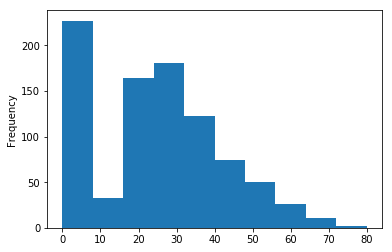

In [5]:
titanic_df.info()
#Lets mutate Age to mean

age_mean = np.mean(titanic_df.Age)
fare_mean = np.mean(titanic_df.Fare)
titanic_df[['Age']] = titanic_df[['Age']].fillna(0)
titanic_df.Age.plot(kind='hist')

titanic_df[titanic_df.Age.isna()].head(891-714).to_csv('age.csv')

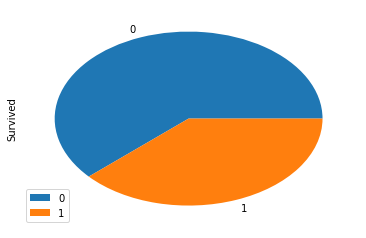

In [6]:
titanic_df['Survived'].value_counts().plot(kind='pie',legend=True)

In [7]:
titanic_df_X = titanic_df.iloc[:,1:]
titanic_df_Y = titanic_df.iloc[:,0]
# print(type(titanic_df_X), type(titanic_df_Y))

In [8]:

titanic_df_X.head()

,Sex,Age,SibSp,Parch,Fare,Cabin0,Embarked,Pclass
0,0,22.0,1,0,7.2500,7,2,3
1,1,38.0,1,0,71.2833,2,0,1
2,1,26.0,0,0,7.9250,7,2,3
3,1,35.0,1,0,53.1000,2,2,1
4,0,35.0,0,0,8.0500,7,2,3


In [9]:
#Trying a Linear Regression
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(titanic_df_X, titanic_df_Y, test_size=0.3, random_state=0)
titanic_df_X.drop(['SibSp', 'Parch','Embarked'], axis=1, inplace=True)
# print(titanic_df_X.columns)

# *****SMOTE USE*****

# sm = SMOTE(random_state=2)
# print(titanic_df_Y)
# titanic_df_X, titanic_df_Y = sm.fit_sample(titanic_df_X, titanic_df_Y.values)

# titanic_df_X = pd.DataFrame(titanic_df_X, columns=['Sex', 'Age', 'Fare', 'Cabin0', 'Pclass'])
# titanic_df_Y = pd.DataFrame(titanic_df_Y, columns=['Survived'])
# titanic_df_X.head()

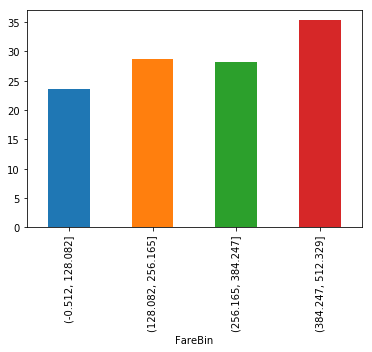

In [10]:
# titanic_df.plot(x='Age', y='Fare', kind='scatter',figsize=(12,8))
titanic_df['FareBin'] = pd.cut(titanic_df.Fare,bins=4) 
age_approx = titanic_df.groupby('FareBin')['Age'].mean()
age_approx.plot(kind='bar')

In [11]:
#Base
type(titanic_df_Y)
# titanic_df_Y.Survived.value_counts()/len(titanic_df_Y)

titanic_df_X = titanic_df_X[['Sex', 'Age', 'Fare']]

model_lr = LogisticRegression()
model_lr.fit(titanic_df_X, titanic_df_Y)

#Base random guess accuracy is 61 percent

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
scaler_= StandardScaler()
print(titanic_df_X.head())
scores = cross_val_score(model_lr, titanic_df_X, titanic_df_Y, cv=10)
scores.mean()

   Sex   Age     Fare
0    0  22.0   7.2500
1    1  38.0  71.2833
2    1  26.0   7.9250
3    1  35.0  53.1000
4    0  35.0   8.0500


0.7822287481557145

In [13]:
# for d in range(1,100):
model_dt = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=12)
model_dt.fit(titanic_df_X, titanic_df_Y)
scores = cross_val_score(model_dt, titanic_df_X, titanic_df_Y, cv=10)
print('{}'.format(scores.mean()))
# ?cross_val_score

0.8081228010441495


In [14]:
model_svm = SVC(C=10)
scores = cross_val_score(model_svm, titanic_df_X, titanic_df_Y, cv=10)
print('{}'.format(scores.mean()))

0.6925011349449551


In [15]:
def my_pipe(titanic_df):
#     print(titanic_df.head())
    gender_ = {'male':0,'female':1}
    titanic_df['Sex'] = titanic_df['Sex'].replace(gender_)
    
    titanic_df['Cabin'] = titanic_df.Cabin.apply(lambda x:str(x).upper())
    titanic_df['Cabin0'] = titanic_df.Cabin.apply(lambda x:str(x)[0])
    titanic_df['Cabin0'] = label_cabin.fit_transform(titanic_df['Cabin0'])
    
    titanic_df['Embarked'] = titanic_df['Embarked'].astype(np.str)
    titanic_df['Embarked'] = label_embark.fit_transform(titanic_df['Embarked'])

    #Lets filter the dataframe
    titanic_df = titanic_df[['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin0', 'Embarked','Pclass']]

    titanic_df[['Age']] = titanic_df[['Age']].fillna(value= 0)
    titanic_df[['Fare']] = titanic_df[['Fare']].fillna(value= fare_mean)
    
#     titanic_df.Fare = StandardScaler().fit_transform(titanic_df.Fare.values.reshape(-1,1))
    
    titanic_df_X = titanic_df.iloc[:,:]
#     titanic_df_X.Age = pd.cut(titanic_df_X.Age, bins=[0,20,40,60,100], labels=['young','adult','mature','old'])
#     titanic_df_X.Age = LabelEncoder().fit_transform(titanic_df_X.Age)
#     titanic_df_X.Fare = titanic_df_X.Fare.apply(np.log10)
    titanic_df_X.drop(['SibSp', 'Parch','Embarked'], axis=1, inplace=True)
    
    titanic_df_X = titanic_df_X[['Sex', 'Age', 'Fare']]
    return titanic_df_X.copy()

In [16]:
titanic_df_test = pd.read_csv('test.csv')
titanic_df_test_X = my_pipe(titanic_df_test)
print(titanic_df_test_X.head())


   Sex   Age     Fare
0    0  34.5   7.8292
1    1  47.0   7.0000
2    0  62.0   9.6875
3    0  27.0   8.6625
4    1  22.0  12.2875


In [17]:
titanic_df_test_X.isna().sum()
print(titanic_df_test_X.Fare.isna().sum())
predicted = model_lr.predict(titanic_df_test_X)

0


In [18]:
titanic_df_test_X.isna().sum()
# print(titanic_df_test_X.shape)
predicted = model_dt.predict(titanic_df_test_X)
titanic_df_submit = pd.DataFrame({'PassengerId': titanic_df_test['PassengerId'],'Survived':  predicted})

filename = 'titanic_submission_2.csv'
titanic_df_submit.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: titanic_submission_2.csv


In [19]:
feat = titanic_df_X.columns.tolist()
feat_score = model_dt.feature_importances_.tolist()
print(feat)
sorted(zip(feat_score,feat), reverse=True)

['Sex', 'Age', 'Fare']


[(0.44291158991161317, 'Fare'),
 (0.2907551066429317, 'Sex'),
 (0.2663333034454551, 'Age')]

In [20]:
# titanic_df_X.Age = pd.cut(titanic_df_X.Age, bins=[0,20,40,60,100], labels=['young','adult','mature','old'])

In [21]:
# titanic_df_X.Age = label_.fit_transform(titanic_df_X.Age)
# titanic_df_X.Age.value_counts()

In [22]:
#Fare Normalization:
# titanic_df_X.Fare = titanic_df_X.Fare.apply(np.log10)
# titanic_df_X.Fare

In [23]:
# for d in range(1,100):
# for x in range(1000,2000,1000):
print(titanic_df_X.min())
model_dt = DecisionTreeClassifier(max_depth=20, criterion='entropy')
model_dt.fit(titanic_df_X, titanic_df_Y)
scores = cross_val_score(model_dt, titanic_df_X, titanic_df_Y, cv=5)
print('{}'.format( scores.mean()))

#     print(classification_report(titanic_df_Y, model_dt.predict(titanic_df_X)))
#     print(roc_auc_score(titanic_df_Y, model_dt.predict(titanic_df_X)))

Sex     0.0
Age     0.0
Fare    0.0
dtype: float64
0.7733510722618411


In [24]:
model_dt.feature_importances_

array([0.23939253, 0.30616618, 0.45444129])

In [25]:
model_lr = LogisticRegression()
model_lr.fit(titanic_df_X, titanic_df_Y)
scores = cross_val_score(model_lr, titanic_df_X, titanic_df_Y, cv=5)
print('{}'.format(scores.mean()))

print(classification_report(titanic_df_Y, model_lr.predict(titanic_df_X)))
print(roc_auc_score(titanic_df_Y, model_lr.predict(titanic_df_X)))

0.7811159495380325
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       549
           1       0.73      0.69      0.71       342

    accuracy                           0.78       891
   macro avg       0.77      0.76      0.77       891
weighted avg       0.78      0.78      0.78       891

0.7643322787843927


In [26]:
# model_svm = SVC(C=1000000)
# model_svm.fit(titanic_df_X, titanic_df_Y)
# scores = cross_val_score(model_svm, titanic_df_X, titanic_df_Y, cv=5)
# print('{}'.format(scores.mean()))

# print(classification_report(titanic_df_Y, model_svm.predict(titanic_df_X)))
# print(roc_auc_score(titanic_df_Y, model_svm.predict(titanic_df_X)))

In [27]:
# titanic_df_test_X.isna().sum()
# # print(titanic_df_test_X.shape)
# predicted = model_svm.predict(titanic_df_test_X)
# titanic_df_submit = pd.DataFrame({'PassengerId': titanic_df_test['PassengerId'],'Survived':  predicted})

# filename = 'titanic_submission_3.csv'
# titanic_df_submit.to_csv(filename,index=False)
# print('Saved file: ' + filename)

In [28]:
# for x in range(1000,6000,1000):
#     model_ada = AdaBoostClassifier(n_estimators=x)
#     model_ada.fit(titanic_df_X, titanic_df_Y)
#     scores = cross_val_score(model_ada, titanic_df_X, titanic_df_Y, cv=5)
#     print('{}: {}'.format(x, scores.mean()))
#     print(classification_report(titanic_df_Y, model_ada.predict(titanic_df_X)))
#     print(roc_auc_score(titanic_df_Y, model_ada.predict(titanic_df_X)))

In [29]:
titanic_df_test_X.head()
from collections import Counter
print(Counter(titanic_df_Y))

Counter({0: 549, 1: 342})


In [30]:
model_ada = AdaBoostClassifier(n_estimators=1000)
model_ada.fit(titanic_df_X, titanic_df_Y)
scores = cross_val_score(model_ada, titanic_df_X, titanic_df_Y, cv=5)
print('{}'.format(scores.mean()))

0.7968585570470393


In [31]:
print(titanic_df_test_X.isna().sum())
print(titanic_df_test_X.head())
predicted = model_ada.predict(titanic_df_test_X)
titanic_df_submit = pd.DataFrame({'PassengerId': titanic_df_test['PassengerId'],'Survived':  predicted})

filename = 'titanic_submission_3.csv'
titanic_df_submit.to_csv(filename,index=False)
print('Saved file: ' + filename)

Sex     0
Age     0
Fare    0
dtype: int64
   Sex   Age     Fare
0    0  34.5   7.8292
1    1  47.0   7.0000
2    0  62.0   9.6875
3    0  27.0   8.6625
4    1  22.0  12.2875
Saved file: titanic_submission_3.csv


In [32]:
# ny, X_test, y_train, y_test = train_test_split(
# ...     X, y, test_size=0.33, random_state=42)

In [33]:
# titanic_df_Y['Survived'].ravel()[4]

In [34]:
#Suppress Warninings
import warnings
warnings.filterwarnings('ignore')


#Machine Learning Algorithm (MLA) Selection and Initialization
from sklearn import ensemble, linear_model, naive_bayes, svm, tree, discriminant_analysis, gaussian_process, neighbors
from sklearn import model_selection
from xgboost import XGBClassifier

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(n_estimators=200),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame()

cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, titanic_df_X, titanic_df_Y, cv  = cv_split)
#     print(cv_results)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
#     MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(titanic_df_X, titanic_df_Y)
    row_index+=1
    MLA_predict[MLA_name] = alg.predict(titanic_df_test_X)
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.801117,0.06235,0.086366
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.784358,0.0536313,0.35637
11,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.778771,0.0170917,0.00160241
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.774302,0.0310848,0.0408973
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.774302,0.0586353,0.00877676
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.772067,0.0246317,0.0652393
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.772067,0.0246317,0.00178919
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.772067,0.0246317,0.00378942
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.772067,0.0442153,0.011577
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.769832,0.0324984,0.00118647


In [35]:
print(MLA_compare.loc[3]['MLA Parameters'])

{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [36]:
# titanic_df_test_X.isna().sum()

model_xgb = MLA[3]

print(titanic_df_test_X.head())
predicted = model_xgb.predict(titanic_df_test_X)
titanic_df_submit = pd.DataFrame({'PassengerId': titanic_df_test['PassengerId'],'Survived':  predicted})

filename = 'titanic_submission_xgb.csv'
titanic_df_submit.to_csv(filename,index=False)
print('Saved file: ' + filename)

   Sex   Age     Fare
0    0  34.5   7.8292
1    1  47.0   7.0000
2    0  62.0   9.6875
3    0  27.0   8.6625
4    1  22.0  12.2875
Saved file: titanic_submission_xgb.csv


In [37]:
#Best Kaggle score: 0.76

Text(0,0.5,'Algorithm')

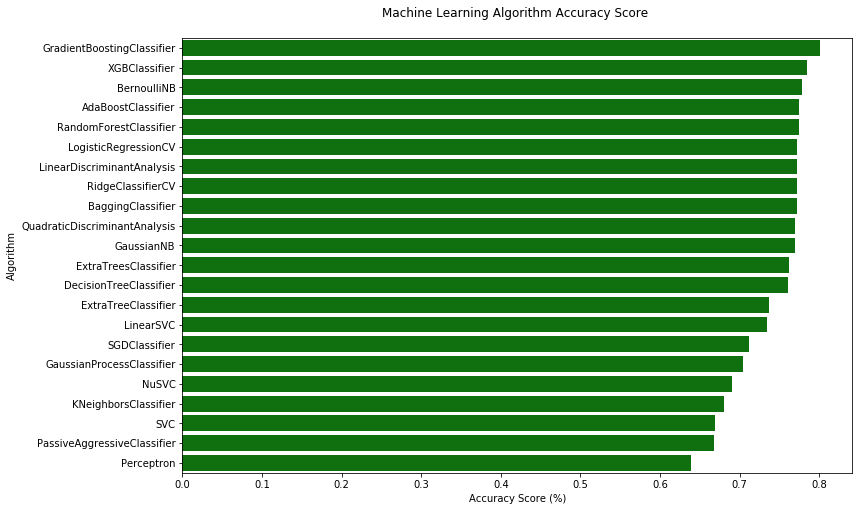

In [38]:
plt.close()

#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
plt.figure(figsize=(12,8))
sb.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'g')
#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')


In [39]:
MLA_compare = MLA_compare.reset_index().set_index('MLA Name')
MLA_compare.drop('index', axis=1,inplace=True)
MLA_compare

,MLA Parameters,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
MLA Name,,,,
GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.801117,0.06235,0.086366
XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.784358,0.0536313,0.35637
BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.778771,0.0170917,0.00160241
AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.774302,0.0310848,0.0408973
RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.774302,0.0586353,0.00877676
LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.772067,0.0246317,0.0652393
LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.772067,0.0246317,0.00178919
RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.772067,0.0246317,0.00378942
BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.772067,0.0442153,0.011577


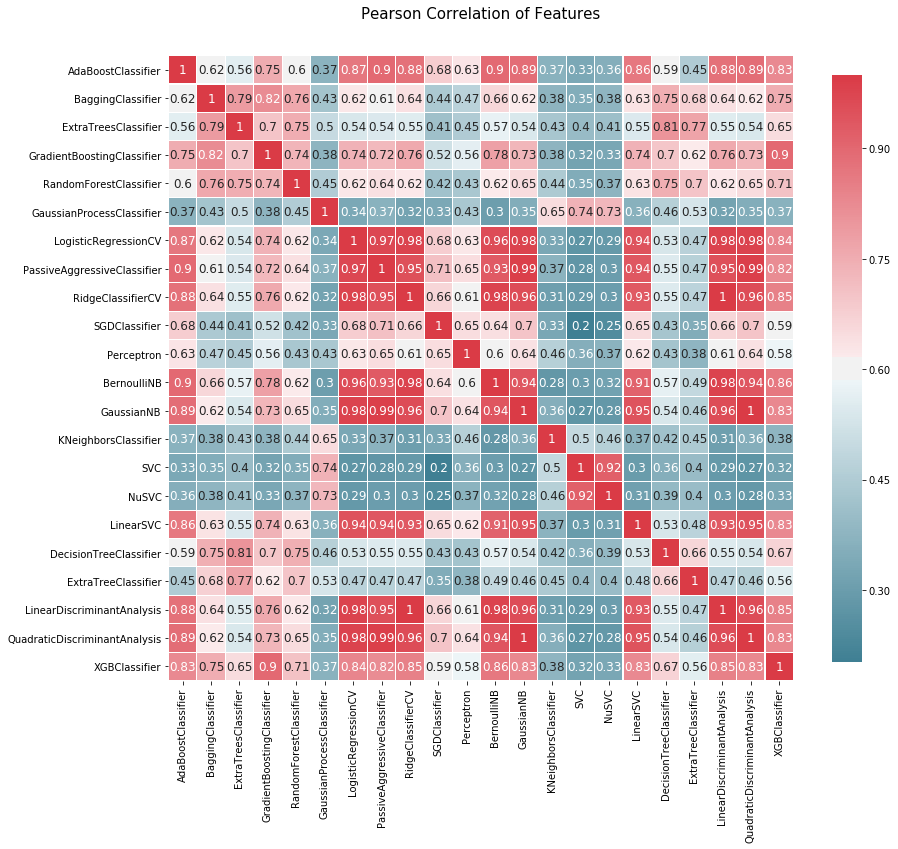

In [40]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sb.diverging_palette(220, 10, as_cmap = True)
    
    _ = sb.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    return df.corr()

ml_alg_corr = correlation_heatmap(MLA_predict)

In [41]:
my_list= list()
for x in ml_alg_corr.index:
    for y in ml_alg_corr.index:
        if(ml_alg_corr.loc[x,y]<=0.1):
            my_list.append(tuple([x,y]))
#             my_list.append(x)

In [42]:
my_list_ref = [x[0] for x in my_list]
sorted(list(set(my_list_ref)))

[]

In [43]:
#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    
    ('gbc', ensemble.GradientBoostingClassifier()),
    
    ('rfc', ensemble.RandomForestClassifier()),
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier()),


]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, titanic_df_X, titanic_df_Y, cv  = cv_split)
vote_hard.fit(titanic_df_X, titanic_df_Y)

# print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, titanic_df_X, titanic_df_Y, cv  = cv_split)
vote_soft.fit(titanic_df_X, titanic_df_Y)

# print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Test w/bin score mean: 76.98
Hard Voting Test w/bin score 3*std: +/- 9.20
----------
Soft Voting Test w/bin score mean: 77.99
Soft Voting Test w/bin score 3*std: +/- 9.92
----------


In [44]:
# titanic_df_test_X.isna().sum()

# model_xgb = MLA[3]

print(titanic_df_test_X.head())
predicted = vote_hard.predict(titanic_df_test_X)
titanic_df_submit = pd.DataFrame({'PassengerId': titanic_df_test['PassengerId'],'Survived':  predicted})

filename = 'titanic_submission_hard_voting.csv'
titanic_df_submit.to_csv(filename,index=False)
print('Saved file: ' + filename)

   Sex   Age     Fare
0    0  34.5   7.8292
1    1  47.0   7.0000
2    0  62.0   9.6875
3    0  27.0   8.6625
4    1  22.0  12.2875
Saved file: titanic_submission_hard_voting.csv


In [45]:
# titanic_df_test_X.isna().sum()

# model_xgb = MLA[3]

print(titanic_df_test_X.head())
predicted = vote_soft.predict(titanic_df_test_X)
titanic_df_submit = pd.DataFrame({'PassengerId': titanic_df_test['PassengerId'],'Survived':  predicted})

filename = 'titanic_submission_sft_voting.csv'
titanic_df_submit.to_csv(filename,index=False)
print('Saved file: ' + filename)

   Sex   Age     Fare
0    0  34.5   7.8292
1    1  47.0   7.0000
2    0  62.0   9.6875
3    0  27.0   8.6625
4    1  22.0  12.2875
Saved file: titanic_submission_sft_voting.csv


In [46]:
#Grid Search
import time
#Code is written for experimental/developmental purposes and not production ready!

#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [

            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],

            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip(vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(titanic_df_X, titanic_df_Y)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

# The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 37.28 seconds.
# The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 33.04 seconds.
# The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 68.93 seconds.
# The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 38.77 seconds.
# The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 84.14 seconds.
# The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 6.19 seconds.
# The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_state': 0, 'solver': 'liblinear'} with a runtime of 9.40 seconds.
# The best parameter for BernoulliNB is {'alpha': 0.1} with a runtime of 0.24 seconds.
# The best parameter for GaussianNB is {} with a runtime of 0.05 seconds.
# The best parameter for KNeighborsClassifier is {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'} with a runtime of 5.56 seconds.
# The best parameter for SVC is {'C': 2, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0} with a runtime of 30.49 seconds.
# The best parameter for XGBClassifier is {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0} with a runtime of 43.57 seconds.
# Total optimization time was 5.96 minutes.
# ----------

The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'random_state': 0} with a runtime of 16.62 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 300, 'oob_score': True, 'random_state': 0} with a runtime of 24.94 seconds.
The best parameter for KNeighborsClassifier is {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'} with a runtime of 1.00 seconds.
The best parameter for SVC is {'C': 3, 'decision_function_shape': 'ovo', 'gamma': 0.25, 'probability': True, 'random_state': 0} with a runtime of 23.67 seconds.
The best parameter for XGBClassifier is {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 50, 'seed': 0} with a runtime of 46.72 seconds.
Total optimization time was 1.88 minutes.
----------


In [47]:
#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, titanic_df_X, titanic_df_Y, cv  = cv_split)
vote_hard.fit(titanic_df_X, titanic_df_Y)

# print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, titanic_df_X, titanic_df_Y, cv  = cv_split)
vote_soft.fit(titanic_df_X, titanic_df_Y)

# print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Test w/bin score mean: 79.89
Hard Voting Test w/bin score 3*std: +/- 6.36
----------
Soft Voting Test w/bin score mean: 78.88
Soft Voting Test w/bin score 3*std: +/- 9.91
----------


In [48]:
# titanic_df_test_X.isna().sum()

# model_xgb = MLA[3]

print(titanic_df_test_X.head())
predicted = vote_hard.predict(titanic_df_test_X)
titanic_df_submit = pd.DataFrame({'PassengerId': titanic_df_test['PassengerId'],'Survived':  predicted})

filename = 'titanic_submission_hard_voting.csv'
titanic_df_submit.to_csv(filename,index=False)
print('Saved file: ' + filename)

   Sex   Age     Fare
0    0  34.5   7.8292
1    1  47.0   7.0000
2    0  62.0   9.6875
3    0  27.0   8.6625
4    1  22.0  12.2875
Saved file: titanic_submission_hard_voting.csv
